In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform

In [2]:
np.set_printoptions(suppress=True)

<h2>0.1. Предварительная обработка данных</h2>

In [3]:
X = pd.read_excel('X_4_13.xlsx', header=None)

Y = pd.read_excel('Y_4_13.xlsx', header=None)

X

,0,1,2,3
0,5.092168,1.034724,7.080165,-1.987996
1,4.846424,0.968371,6.787735,-1.941311
2,5.297292,1.205368,6.978480,-1.681188
3,3.729736,0.846779,4.919136,-1.189400
4,5.003340,1.094723,6.722511,-1.719171
...,...,...,...,...
195,3.674291,0.826147,4.870143,-1.195852
196,3.711996,0.911068,4.690788,-0.978792
197,4.504129,0.705877,6.890626,-2.386497
198,4.891603,0.973449,6.862858,-1.971255


In [4]:
X.describe()

,0,1,2,3
count,200.000000,200.000000,200.000000,200.000000
mean,2.999880,0.978973,3.062841,-0.062961
std,2.665400,1.190919,2.636290,1.659201
min,-1.770611,-1.098890,-1.686545,-3.001601
25%,0.967169,0.094967,1.037855,-1.337723
50%,3.043348,1.013192,3.001980,-0.003096
75%,5.053307,1.939336,5.064147,1.147939
max,7.684823,3.085918,8.097899,3.110166


In [5]:
X.isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

<AxesSubplot:>

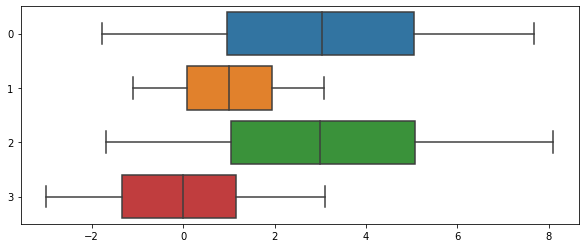

In [6]:
plt.figure(figsize=(10,4))
sns.boxplot(data=X, orient='h')

In [7]:
Y

,0,1,2,3
0,0.906940,1.006914,0.963778,0.824834
1,2.029085,0.799312,1.623610,0.952911
2,1.978421,1.102946,1.458704,0.978444
3,2.275134,0.829438,1.964464,1.040498
4,1.276684,0.056152,-0.198731,1.130742
...,...,...,...,...
195,2.011200,0.939179,1.924253,0.916095
196,2.166127,1.092028,1.849896,1.069608
197,1.004772,0.952281,0.960462,0.711798
198,1.894961,0.872430,1.811809,1.079972


In [8]:
Y.isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

<AxesSubplot:>

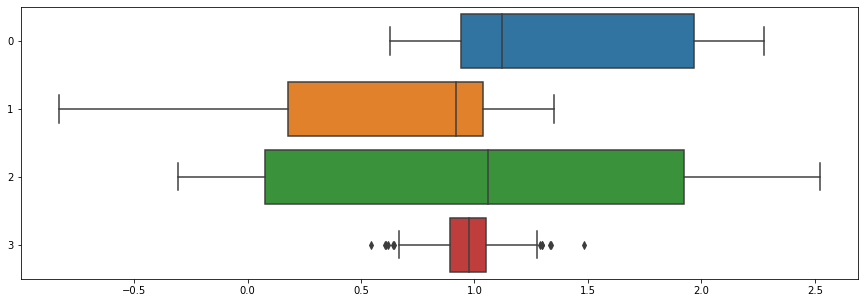

In [9]:
plt.figure(figsize=(15,5))
sns.boxplot(data=Y, orient='h')

Стандартизируем данные, используя z-оценку:

In [10]:
X_st = pd.DataFrame(zscore(X))
Y_st = pd.DataFrame(zscore(Y))

Чтобы сделать предварительные выводы о количестве и видах кластеров, а также выбрать подходящий алгоритм кластеризации, визуализируем данные, предварительно уменьшив их размерность до n=2. Чтобы понять, насколько будет велика погрешность в этом случае, выполним SVD-разложение и рассчитаем ошибку аппроксимации:

In [11]:
def count_approx_error(S):
    ev_table = pd.DataFrame()

    pc_num = [i+1 for i in range(len(S))]
    
    ev_table[0] = pc_num
    
    ev_table[1] = S.round(2)
    
    qrS = S ** 2
    
    ev_table[2] = qrS.round(2)
   
    percentvar = [round(i/sum(qrS)*100,2) for i in S**2]
    
    ev_table[3] = percentvar
    
    ev_table[4] = np.cumsum(percentvar)

    ev_table.columns=['Главные факторы', 'Сингулярные значения',
                                    'Собственные значения', 'Вклад в вариацию(%)',
                                    'Кумулятивный вклад в вариацию(%)']
    return ev_table

In [12]:
Ux, Sx, VTx = np.linalg.svd(X_st)
count_approx_error(Sx)

,Главные факторы,Сингулярные значения,Собственные значения,Вклад в вариацию(%),Кумулятивный вклад в вариацию(%)
0,1,22.83,521.26,65.16,65.16
1,2,16.70,278.74,34.84,100.00
2,3,0.00,0.00,0.00,100.00
3,4,0.00,0.00,0.00,100.00


In [13]:
Uy, Sy, VTy = np.linalg.svd(Y_st)
count_approx_error(Sy)

,Главные факторы,Сингулярные значения,Собственные значения,Вклад в вариацию(%),Кумулятивный вклад в вариацию(%)
0,1,22.11,488.90,61.11,61.11
1,2,14.20,201.64,25.20,86.31
2,3,9.92,98.34,12.29,98.60
3,4,3.33,11.12,1.39,99.99


В случае с датасетом X первые 2 признака сохраняют 100% информации. В случае с датасетом Y при n = 2 ошибка  составляет 13.69%, что достаточно мало для того, чтобы ориентироваться на такую аппроксимацию.

Теперь визуализируем данные: построим карты объектов для X и для Y.

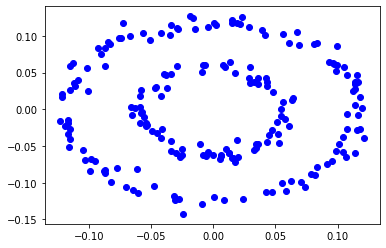

In [14]:
X_2d = Ux[:,:2]
plt.plot(X_2d[:,0], X_2d[:,1],'bo')

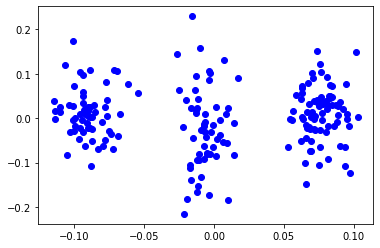

In [15]:
Y_2d = Uy[:,:2]
plt.plot(Y_2d[:,0], Y_2d[:,1],'bo')

В датасете Y мы видим 3 четко сформированных кластера примерно одинакового размера, для каждого из которых можно найти центр. Предположительно любой алгоритм, использующий центры кластеров, даст соответствующий результат.

Датасет X представляет собой 2 концентрических кластера, не имеющих центра. Вероятно, стандартные алгоритмы не смогут выполнить кластеризацию правильным образом.

<h2>0.2. Подготовка данных</h2>

In [17]:
from sklearn.manifold import MDS

In [18]:
metrics = ('mahalanobis', 'correlation', 'minkowski', 'euclidean')

dist_m_x = {}

dist_m_y = {}

for metric in metrics:
    
    dist_m_x[metric] = pdist(X_st, metric, p=1)
    
    dist_m_y[metric] = pdist(Y_st, metric, p=1)
    
dist_m_x = pd.DataFrame(dist_m_x)
dist_m_y = pd.DataFrame(dist_m_y)

Корреляции между расстояниями:

In [19]:
dist_m_x.corr('kendall')

,mahalanobis,correlation,minkowski,euclidean
mahalanobis,1.000000,0.539039,0.779450,0.813653
correlation,0.539039,1.000000,0.431137,0.460070
minkowski,0.779450,0.431137,1.000000,0.947866
euclidean,0.813653,0.460070,0.947866,1.000000


In [20]:
dist_m_y.corr('kendall')

,mahalanobis,correlation,minkowski,euclidean
mahalanobis,1.000000,0.388785,0.538976,0.577128
correlation,0.388785,1.000000,0.426155,0.434227
minkowski,0.538976,0.426155,1.000000,0.889614
euclidean,0.577128,0.434227,0.889614,1.000000


Выберем расстояние следующим образом: на основе матрицы расстояний проведем многомерное шкалирование и визуализируем результаты. Мы предполагаем, что метрика расстояния подойдет для решения данной задачи, если полученные на ее основе 2-мерные векторы образуют то же количество кластеров с примерно тем же количеством элементов в каждом из них.

In [21]:
def perform_mds(dist_m):
    
    for distance_matrix in dist_m:
        
        print('Метрика: {}'.format(distance_matrix))
        
        tmp_new = embedding.fit_transform(squareform(dist_m[distance_matrix]))
        
        plt.plot(tmp_new[:,0], tmp_new[:,1],'bo')
        
        plt.show()

MDS для датасета X:

Метрика: mahalanobis


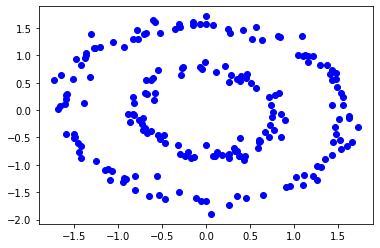

Метрика: correlation


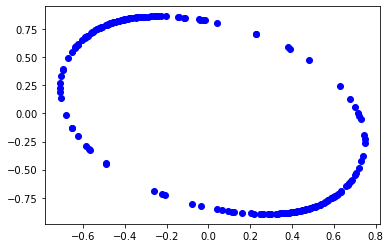

Метрика: minkowski


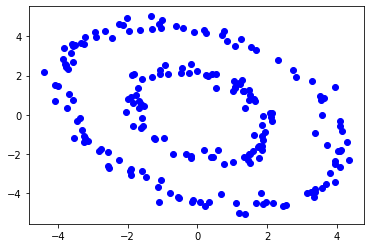

Метрика: euclidean


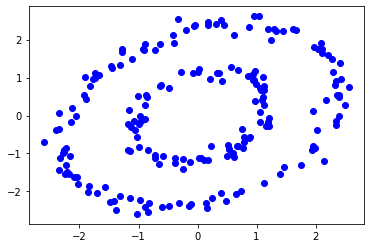

In [22]:
embedding = MDS(n_components=2, dissimilarity = 'precomputed', eps=1e-6)

perform_mds(dist_m_x)

Датасет Y:

Метрика: mahalanobis


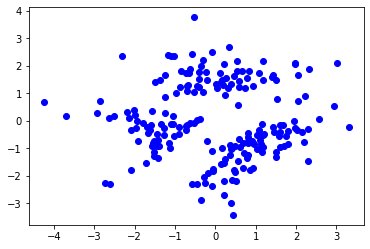

Метрика: correlation


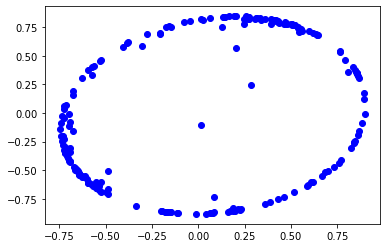

Метрика: minkowski


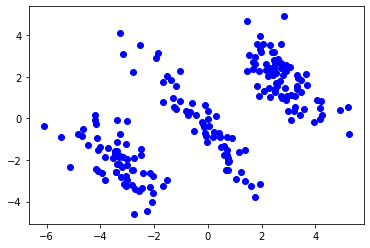

Метрика: euclidean


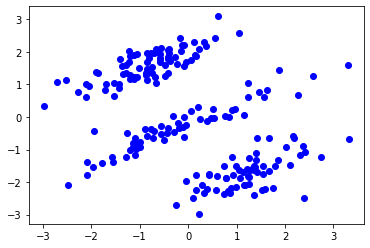

In [23]:
perform_mds(dist_m_y)

Видно, что структура кластеров сохраняется для всех расстояний, кроме корреляции, но точнее всего повторяют карту объектов векторы, полученные на основе евклидова расстояния. Его и будем использовать для кластеризации.

Получим матрицу близости на основе матрицы расстояний и построим графовую модель для каждого датасета:

In [22]:
def similarity_to_graph(sim_mat):
    n = sim_mat.shape[0]
    G = nx.Graph()
    _ = [G.add_node(i for i in range(n))]
    for i in range(len(sim_mat)-1):
        for j in range(i+1,len(sim_mat)):
            w = sim_mat[i][j]
            G.add_edge(i, j, weight=w)
        
    G.remove_node(list(G.nodes)[0])
    return G

In [23]:
X_dis = squareform(pdist(X_st, 'euclidean'))
similarity_X = np.exp(-X_dis * 1/4)
X_graph = similarity_to_graph(similarity_X)

In [24]:
Y_dis = squareform(pdist(Y_st, 'euclidean'))
similarity_Y = np.exp(-Y_dis * 1/4)
Y_graph = similarity_to_graph(similarity_Y)

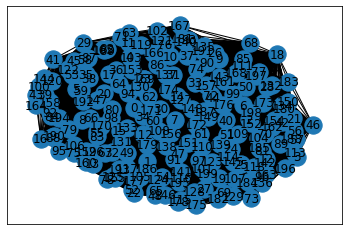

In [25]:
pos=nx.spring_layout(Y_graph)
nx.draw_networkx(Y_graph,pos)